<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Regularización _dropout_<a id="top"></a>

<i><small>Última actualización: 2024-03-07</small></i></div>

***

## Introducción

Vamos a reflexionar un poco sobre lo que se espera de un buen modelo predictivo: queremos que tenga un buen rendimiento con datos nunca vistos durante el entrenamientose desempeñe bien con datos no vistos. La teoría clásica de la generalización siempre ha sugerido que, para tener modelos más generalistas, debemos apuntar hacia modelos lo más simples posible.

Sin embargo, en 2014, [Srivastava et al.](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) propusieron un nuevo punto de vista para generalizar. Curiosamente, la analogía fue hecha por ellos con la reproducción sexual. Los autores argumentaron que el sobreajuste de las redes neuronales se caracteriza por un estado en el cual cada capa depende de un patrón específico de activaciones de la capa anterior, a lo cual llaman coadaptación. El _dropout_, según ellos, rompe esta coadaptación de la misma manera que la reproducción sexual rompe los genes coadaptados.

El **_dropout_** es una técnica de regularización utilizada para prevenir el sobreajuste en las redes neuronales. Durante el entrenamiento, implica «apagar» algunos neuronas seleccionadas al azar en la red en cada iteración. Esto fuerza a la red a **que todas las neuronas aprendan de todos los ejemplos**, haciéndola más robusta y menos propensa al sobreajuste.

<center>
<figure class="image">
    <img src="https://etsisi.github.io/Aprendizaje-profundo/Slides/images/dropout.png" alt="Esquema de un MLP antes y después del Dropout" />
    <figcaption><em><strong>Figura 1.</strong>Esquema de un MLP antes y después del Dropout.</em></figcaption>
</figure>
</center>

Lo normal es que una vez terminado el entrenamiento el _dropout_ se desactive, ya que la idea es que reparta el conocimiento a través de todas las neuronas durante el entrenamiento. No obstante, hay algunas excepciones: algunos autores utilizan el _dropout_ también durante el cálculo de la precisión con el conjunto de prueba como una heurística para la incertidumbre de las predicciones de la red neuronal. Es decir, si las predicciones coinciden en muchas diferentes permutaciones de _dropout_, entonces podríamos afirmar con cierta confianza que nuestro modelo es más robusto.

## Opjetivos

El propósito será implementar un modelo de perceptrón multicapa bastante grande, que sea capaz de clasificar los datos en el conjunto de datos mnist, pero que haya sido regularizado con _dropout_ para intentar asegurar que su potencia no afecte su capacidad de generalización.

## Bibliotecas y configuración

A continuación, importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

2024-03-08 18:50:55.901323: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 18:50:55.905475: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 18:50:55.971297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 18:50:57.808391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Preparación de datos

Usaremos el conjunto de datos `mnist` que hemos usado previamente y que nos viene de maravilla para este propósito.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Usando dropout en Keras

La verdad es que es bastante fácil. Con Keras (y en general con cualquier API de alto nivel), todo lo que tenemos que hacer es añadir una capa `Dropout` después de la capa conectada a la cual queremos aplicar la regularización. El único parámetro que hay que pasar al constructor es la probabilidad de que una neurona sea o no desactivada.

Durante el entrenamiento, esta capa eliminará aleatoriamente las salidas de la capa anterior (y por lo tanto las entradas de la siguiente capa) de acuerdo con la probabilidad especificada. Cuando no está en modo de entrenamiento,  simplemente pasa los datos sin modificar.

Veamos primero cómo funcionarían dos modelos similares para el problema de `mnist`. Primero uno sin capa `Dropout`.

In [4]:
model_wo_do = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_wo_do.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['categorical_accuracy'])
model_wo_do.summary()

history_wo_do = model_wo_do.fit(x_train, y_train, epochs=250, batch_size=len(x_train), validation_split=0.1, verbose=1)

/home/blazaid/.cache/pypoetry/virtualenvs/aprendizaje_profundo-9KsGUE1K-py3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250


2024-03-08 18:51:00.878712: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.
2024-03-08 18:51:04.772160: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.
2024-03-08 18:51:04.887555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 171504000 bytes after encountering the first element of size 171504000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-08 18:51:04.887833: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55296000 exceeds 10% of free system memory.
2024-03-08 18:51:05.157410: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55296000 exceeds 10% of free system memory.
2024-03-08 18:51:05.261533: W external/local_tsl/tsl/framework/cpu

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - categorical_accuracy: 0.1127 - loss: 2.3230 - val_categorical_accuracy: 0.3742 - val_loss: 2.1293
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step - categorical_accuracy: 0.3489 - loss: 2.1410 - val_categorical_accuracy: 0.5942 - val_loss: 1.9599
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - categorical_accuracy: 0.5669 - loss: 1.9776 - val_categorical_accuracy: 0.7080 - val_loss: 1.7931
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step - categorical_accuracy: 0.6757 - loss: 1.8167 - val_categorical_accuracy: 0.7562 - val_loss: 1.6221
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step - categorical_accuracy: 0.7220 - loss: 1.6519 - val_categorical_accuracy: 0.7828 - val_loss: 1.4465
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 0.7516 - loss: 1.4827 - val_categorical_accuracy: 0.8060 - val_loss: 1.2702
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step - categorical_accuracy: 0.7739 - loss: 1.3132 - val_categoric

Veamos cómo ha evolucionado el entrenamiento.

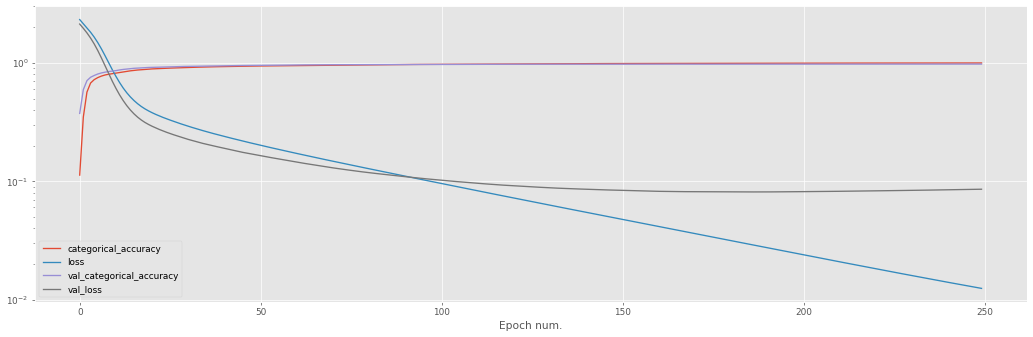

In [5]:
pd.DataFrame(history_wo_do.history).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

Y ahora uno con _dropout_. En Keras, implementar el dropout es sencillo. Se utiliza una capa especial llamada `Dropout`, que se inserta entre las capas consecutivas de la red neuronal. La capa Dropout toma un argumento llamado `rate`, que especifica la fracción de neuronas que se desactivarán en cada iteración. Aquí hay un ejemplo:

In [6]:
model_wi_do = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_wi_do.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])
model_wi_do.summary()

history_wi_do = model_wi_do.fit(x_train, y_train, epochs=250, batch_size=len(x_train), validation_split=0.1, verbose=1)

/home/blazaid/.cache/pypoetry/virtualenvs/aprendizaje_profundo-9KsGUE1K-py3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1017 - loss: 2.4428 - val_accuracy: 0.3258 - val_loss: 2.1582
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step - accuracy: 0.1720 - loss: 2.2524 - val_accuracy: 0.5307 - val_loss: 2.0075
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 0.2604 - loss: 2.1068 - val_accuracy: 0.6247 - val_loss: 1.8677
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step - accuracy: 0.3446 - loss: 1.9806 - val_accuracy: 0.6722 - val_loss: 1.7280
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step - accuracy: 0.4230 - loss: 1.8590 - val_accuracy: 0.7128 - val_loss: 1.5845
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step - accuracy: 0.4813 - loss: 1.7384 - val_accuracy: 0.7530 - val_loss: 1.4377
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step - accuracy: 0.5296 - loss: 1.6197 - val_accuracy: 0.7780 - val_loss: 1.2901
Epoch 8/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step - accuracy: 0.5603 - loss: 1.5119 - val_accuracy: 0.8052 - val_

En este ejemplo, hemos añadido dos capas de `Dropout` con una tasa del $50\%$. Esto significa que la mitad de las neuronas se desactivarán aleatoriamente durante cada _batch_ (no _apoch). Esto es un valor bastante común, pero no es el único. En general, el valor de la tasa de _dropout_ es un hiperparámetro que se puede ajustar para obtener el mejor rendimiento del modelo.

Y veamos también su evolución:

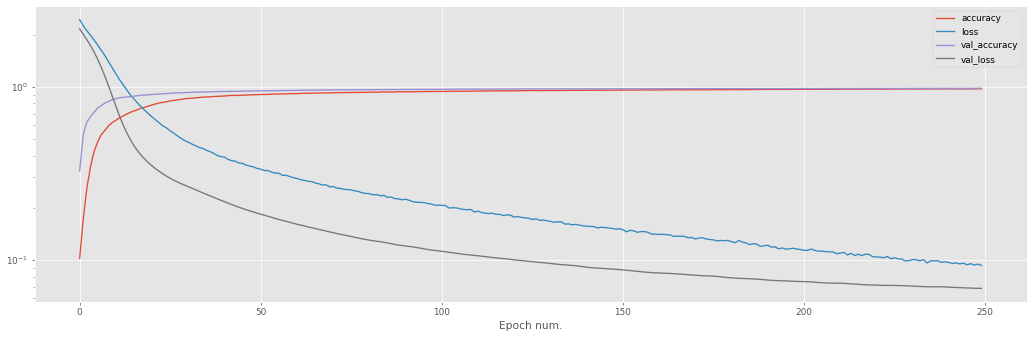

In [7]:
pd.DataFrame(history_wi_do.history).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

Comparemos los valores obtenidos de los conjuntos de ambos modelos:

In [8]:
print('Without dropout:')
train_loss_1, train_accuracy_1 = model_wo_do.evaluate(x_train, y_train, verbose=0)
test_loss_1, test_accuracy_1 = model_wo_do.evaluate(x_test, y_test, verbose=0)
print(f'\tLoss     -> Train: {train_loss_1}, Test: {test_loss_1}')
print(f'\tAccuracy -> Train: {train_accuracy_1}, Test: {test_accuracy_1}')
print('With dropout:')
train_loss_2, train_accuracy_2 = model_wi_do.evaluate(x_train, y_train, verbose=0)
test_loss_2, test_accuracy_2 = model_wi_do.evaluate(x_test, y_test, verbose=0)
print(f'\tLoss     -> Train: {train_loss_2}, Test: {test_loss_2}')
print(f'\tAccuracy -> Train: {train_accuracy_2}, Test: {test_accuracy_2}')

Without dropout:
	Loss     -> Train: 0.0196145698428154, Test: 0.08087362349033356
	Accuracy -> Train: 0.996483325958252, Test: 0.9761999845504761
With dropout:
	Loss     -> Train: 0.042701009660959244, Test: 0.07801009714603424
	Accuracy -> Train: 0.9873833060264587, Test: 0.9763000011444092


El _dropout_ funciona forzando a la red neuronal a aprender características redundantes en distintos subconjuntos de neuronas. Durante el entrenamiento, la red neuronal se ve obligada a aprender características redundantes en diferentes subconjuntos de neuronas, lo que la hace más robusta y menos propensa al sobreajuste. La tendencia general observada es que en los modelos muy potentes el conocimiento tiende a repartirse entre todas las conexiones del modelo, lo que hace que se mitigue la sobreespecialización y aumente la generalización.

## Conclusiones

Hemos realizado una comparación entre dos modelos, uno sin _dropout_ y otro con él, y hemos demostrado que el uso del _dropout_ puede mejorar significativamente la capacidad predictiva de los modelos. Además, hemos explicado cómo funciona el _dropout_ y cómo se puede ajustar su hiperparámetro para optimizar su rendimiento.

El _dropout_ es una técnica muy eficaz para evitar el sobreajuste en las redes neuronales. Consiste en apagar aleatoriamente algunas neuronas de la red durante cada iteración de entrenamiento, forzando a la red a aprender características redundantes a través de diferentes subconjuntos de neuronas. En Keras, la implementación de dropout es sencilla utilizando la capa `Dropout`.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>